/home/user/anaconda3/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:165: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/tmp/ipykernel_385903/1007748482.py:58: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(tumor, color=['Cd3g', 'Trac'], size=1.5, show=False, ncols=2)


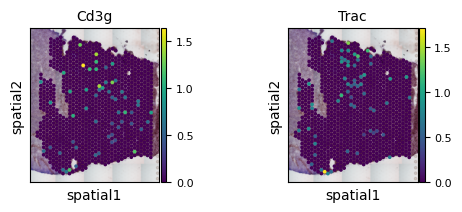

/tmp/ipykernel_385903/1007748482.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df_plot, x='tcr_gene_marker', y='signature_score',


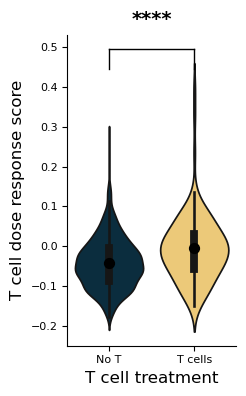

/tmp/ipykernel_385903/1007748482.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=mhc_df_plot, x='tcr_gene_marker', y='signature_score',


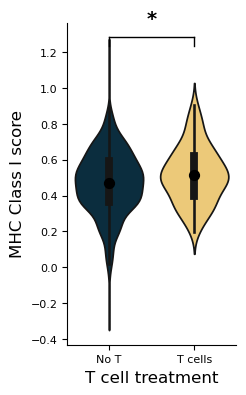

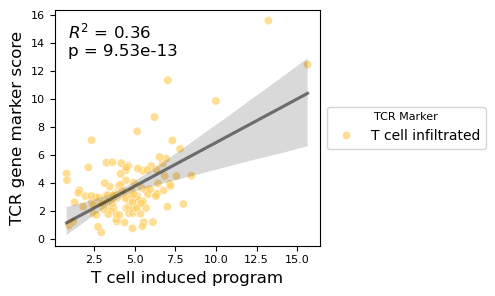

All plots saved to: /home/user/Documents/Kinase_project/figures/spatial_data/


In [2]:
# Imports
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata
from scipy import stats
from scipy.spatial import cKDTree
import pyreadr

# Set output directory
output_dir = '/home/user/Documents/Kinase_project/figures/spatial_data/'
os.makedirs(output_dir, exist_ok=True)

# Set matplotlib parameters
mpl.rcParams.update({'font.size': 8, 'svg.fonttype': 'none'})
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 10

# Define color palette
color_palette = {'No T cells': '#023047', 'T cell infiltrated': '#FFD166'}

# Load data
result = pyreadr.read_r('/home/user/Documents/Kinase_project/crispra_final/CRISPRA_Figures/NTC_analysis/DEG_testing/NTC_CRISPR_dose_response_diff_test_replicates.rds')
data = result[None]

T_cell_dose_gene = (data[(data['term'] == "dose") & (data['q_value'] < 0.05)]
                    .nlargest(30, 'normalized_effect'))

adata = anndata.read_h5ad('/home/user/Documents/Kinase_project_backup/LauraGraciaVicente/GSM7839621_10xVisium_annotated.h5ad')
tumor = adata[adata.obs['condition'].isin(['tumor'])]

# Define genes
tcr_genes_mouse = ["Trac", "Trbc1", "Trbc2"]
mouse_genes = [g.capitalize() for g in T_cell_dose_gene['gene_short_name']]
tcelldose_genes_mouse = [g for g in mouse_genes if g in tumor.var_names]

# Score cells
sc.tl.score_genes(tumor, tcelldose_genes_mouse, score_name='signature_score')

mhc_genes = ["PSMB5", "PSMB6", "PSMB7", "PSMB8", "PSMB9", "PSMB10", "TAP1", "TAP2", 
             "ERAP1", "ERAP2", "CANX", "CALR", "PDIA3", "TAPBP", "B2M", "H2K1", "H2D1", "H2L"]
mhc_genes_present = [g.capitalize() for g in mhc_genes if g.capitalize() in tumor.var_names]
sc.tl.score_genes(tumor, mhc_genes_present, score_name='MHC_class_I_score')

# Create categories
tumor.obs['tcr_gene_marker'] = (tumor[:, tcr_genes_mouse].X.sum(axis=1) > 0).astype(bool)
tumor.obs['tcr_gene_marker'] = tumor.obs['tcr_gene_marker'].map({True: "T cell infiltrated", False: "No T cells"})
tumor.obs['tcr_gene_marker'] = pd.Categorical(tumor.obs['tcr_gene_marker'], categories=["No T cells", "T cell infiltrated"])

# Figure 1: CD3G and TRAC spatial
mpl.rcParams['figure.figsize'] = (2, 2)
sc.pl.spatial(tumor, color=['Cd3g', 'Trac'], size=1.5, show=False, ncols=2)
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(f"{output_dir}/cd3g_trac.{ext}", bbox_inches='tight', transparent=True, dpi=600)
plt.show()

# Figure 2: T cell dose response violin
data_dict = {cat: tumor.obs.loc[tumor.obs['tcr_gene_marker'] == cat, 'signature_score'].values 
             for cat in ["No T cells", "T cell infiltrated"]}
df_plot = pd.DataFrame({'signature_score': np.concatenate(list(data_dict.values())),
                        'tcr_gene_marker': np.concatenate([[k]*len(v) for k, v in data_dict.items()])})

plt.figure(figsize=(2.5, 4))
ax = sns.violinplot(data=df_plot, x='tcr_gene_marker', y='signature_score', 
                    palette=[color_palette['No T cells'], color_palette['T cell infiltrated']], 
                    order=["No T cells", "T cell infiltrated"])
for i, cat in enumerate(["No T cells", "T cell infiltrated"]):
    plt.scatter(i, np.mean(data_dict[cat]), color='black', s=50, zorder=10)

stat, pvalue = stats.mannwhitneyu(data_dict["No T cells"], data_dict["T cell infiltrated"])
y_max = df_plot['signature_score'].max()
y_sig = y_max + 0.1
plt.plot([0, 1], [y_sig, y_sig], 'k-', linewidth=1)
plt.plot([0, 0], [y_sig, y_sig-0.05], 'k-', linewidth=1)
plt.plot([1, 1], [y_sig, y_sig-0.05], 'k-', linewidth=1)
stars = '****' if pvalue < 0.0001 else '***' if pvalue < 0.001 else '**' if pvalue < 0.01 else '*' if pvalue < 0.05 else 'ns'
plt.text(0.5, y_sig + 0.05, stars, ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.ylabel('T cell dose response score', fontsize=12)
plt.xlabel('T cell treatment', fontsize=12)
plt.xticks([0, 1], ['No T', 'T cells'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

for ext in ['pdf', 'png', 'svg']:
    plt.savefig(f'{output_dir}/T_cell_dosage_gene_diff.{ext}', bbox_inches='tight', transparent=True, dpi=900)
plt.show()

# Figure 3: MHC Class I violin
mhc_data_dict = {cat: tumor.obs.loc[tumor.obs['tcr_gene_marker'] == cat, 'MHC_class_I_score'].values 
                 for cat in ["No T cells", "T cell infiltrated"]}
mhc_df_plot = pd.DataFrame({'signature_score': np.concatenate(list(mhc_data_dict.values())),
                            'tcr_gene_marker': np.concatenate([[k]*len(v) for k, v in mhc_data_dict.items()])})

plt.figure(figsize=(2.5, 4))
ax = sns.violinplot(data=mhc_df_plot, x='tcr_gene_marker', y='signature_score',
                    palette=[color_palette['No T cells'], color_palette['T cell infiltrated']],
                    order=["No T cells", "T cell infiltrated"])
for i, cat in enumerate(["No T cells", "T cell infiltrated"]):
    plt.scatter(i, np.mean(mhc_data_dict[cat]), color='black', s=50, zorder=10)

mhc_stat, mhc_pvalue = stats.mannwhitneyu(mhc_data_dict["No T cells"], mhc_data_dict["T cell infiltrated"])
y_max = mhc_df_plot['signature_score'].max()
y_sig = y_max + 0.1
plt.plot([0, 1], [y_sig, y_sig], 'k-', linewidth=1)
plt.plot([0, 0], [y_sig, y_sig-0.05], 'k-', linewidth=1)
plt.plot([1, 1], [y_sig, y_sig-0.05], 'k-', linewidth=1)
stars = '****' if mhc_pvalue < 0.0001 else '***' if mhc_pvalue < 0.001 else '**' if mhc_pvalue < 0.01 else '*' if mhc_pvalue < 0.05 else 'ns'
plt.text(0.5, y_sig + 0.05, stars, ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.ylabel('MHC Class I score', fontsize=12)
plt.xlabel('T cell treatment', fontsize=12)
plt.xticks([0, 1], ['No T', 'T cells'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

for ext in ['pdf', 'png', 'svg']:
    plt.savefig(f'{output_dir}/MHCI_score_diff.{ext}', bbox_inches='tight', transparent=True, dpi=900)
plt.show()

# Figure 4: Correlation plot
tcr_extended = ["Trac", "Trbc1", "Trbc2", "Trdc", "Trgc1", "Trgc2", "Cd3g", "Cd3d", "Cd3e", 
                "Cd4", "Cd8a", "Cd8b1", "Cd2", "Thy1", "Cd5", "Cd7", "Ptprc", "Gzma", "Gzmb", 
                "Gzmk", "Prf1", "Nkg7", "Klrg1", "Ccl5", "Il7r", "Lef1", "Tcf7", "Ccr7", "Sell",
                "Cd27", "Cd28", "Cd69", "Cd44", "Cd25", "Icos", "Cd137", "Tnfrsf9"]
tcr_genes_present = [g for g in tcr_extended if g in tumor.var_names]

tumor.obs['tcr_gene_marker_score'] = tumor[:, tcr_genes_present].X.sum(axis=1)
tumor.obs['tcell_dose_gene_marker_score'] = tumor[:, tcelldose_genes_mouse].X.sum(axis=1)
Tcell = tumor[tumor.obs['tcr_gene_marker'] == "T cell infiltrated"]

plt.figure(figsize=(5, 3))
sns.scatterplot(data=Tcell.obs, x='tcell_dose_gene_marker_score', y='tcr_gene_marker_score',
                hue='tcr_gene_marker', palette={"T cell infiltrated": color_palette['T cell infiltrated']}, alpha=0.7)
sns.regplot(data=Tcell.obs, x='tcell_dose_gene_marker_score', y='tcr_gene_marker_score',
            scatter=False, ax=plt.gca(), line_kws={"color": "black", "alpha": 0.5})

correlation, p_value = stats.pearsonr(Tcell.obs['tcell_dose_gene_marker_score'], Tcell.obs['tcr_gene_marker_score'])
plt.text(0.05, 0.95, f'$R^2$ = {correlation**2:.2f}\np = {p_value:.2e}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.xlabel('T cell induced program', fontsize=12)
plt.ylabel('TCR gene marker score', fontsize=12)
plt.legend(title='TCR Marker', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
#plt.title('Correlation between T cell dose response score and TCR marker score')
plt.tight_layout()

for ext in ['pdf', 'png', 'svg']:
    plt.savefig(f'{output_dir}/tcell_dose_tcr_correlation.{ext}', bbox_inches='tight', transparent=True, dpi=900)
plt.show()

print(f"All plots saved to: {output_dir}")

/tmp/ipykernel_385903/1232143685.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_385903/1232143685.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


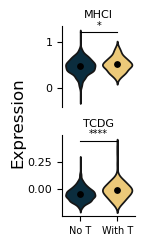

In [4]:
from scipy import stats

# =========================
# Compact 2-row violin: MHCI (top) + TCDG (bottom)
# =========================
df_tcdg = pd.DataFrame({
    'Expression': tumor.obs['signature_score'].values,
    'tcr_gene_marker': tumor.obs['tcr_gene_marker'].values
})
df_mhci = pd.DataFrame({
    'Expression': tumor.obs['MHC_class_I_score'].values,
    'tcr_gene_marker': tumor.obs['tcr_gene_marker'].values
})
order = ["No T cells", "T cell infiltrated"]

fig, axes = plt.subplots(2, 1, figsize=(1.4, 2.5), sharex=True)

# -----------------------------
# Helper: significance stars
# -----------------------------
def star_label(p):
    return (
        "****" if p < 1e-4 else
        "***" if p < 1e-3 else
        "**" if p < 1e-2 else
        "*" if p < 0.05 else
        "ns"
    )

def add_sig(ax, y, p):
    stars = star_label(p)
    ax.plot([0, 1], [y, y], color="black", linewidth=0.8)
    ax.text(0.5, y + 0.02, stars, ha="center", va="bottom", fontsize=7)

# ------------------------
# Top panel: MHCI
# ------------------------
ax1 = axes[0]
sns.violinplot(
    data=df_mhci, x='tcr_gene_marker', y='Expression',
    order=order,
    palette=[color_palette['No T cells'], color_palette['T cell infiltrated']],
    inner=None,
    ax=ax1
)
# Add mean dots
for i, cat in enumerate(order):
    mean_val = df_mhci.loc[df_mhci['tcr_gene_marker'] == cat, 'Expression'].mean()
    ax1.scatter(i, mean_val, color='black', s=15, zorder=10)

ax1.set_title('MHCI', fontsize=8)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', length=0)

# significance for MHCI
p_mhci = stats.mannwhitneyu(
    df_mhci[df_mhci['tcr_gene_marker']=="No T cells"]['Expression'],
    df_mhci[df_mhci['tcr_gene_marker']=="T cell infiltrated"]['Expression']
)[1]
y_max = df_mhci['Expression'].max()
add_sig(ax1, y_max + 0.05, p_mhci)

# ------------------------
# Bottom panel: TCDG
# ------------------------
ax2 = axes[1]
sns.violinplot(
    data=df_tcdg, x='tcr_gene_marker', y='Expression',
    order=order,
    palette=[color_palette['No T cells'], color_palette['T cell infiltrated']],
    inner=None,
    ax=ax2
)
# Add mean dots
for i, cat in enumerate(order):
    mean_val = df_tcdg.loc[df_tcdg['tcr_gene_marker'] == cat, 'Expression'].mean()
    ax2.scatter(i, mean_val, color='black', s=15, zorder=10)

ax2.set_title('TCDG', fontsize=8)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# significance for TCDG
p_tcdg = stats.mannwhitneyu(
    df_tcdg[df_tcdg['tcr_gene_marker']=="No T cells"]['Expression'],
    df_tcdg[df_tcdg['tcr_gene_marker']=="T cell infiltrated"]['Expression']
)[1]
y_max = df_tcdg['Expression'].max()
add_sig(ax2, y_max + 0.05, p_tcdg)

# X-axis labels
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['No T', 'With T'], fontsize=7)

# Shared y label
fig.text(0.02, 0.5, 'Expression', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 1])
for ext in ['pdf', 'png', 'svg']:
    plt.savefig(f'{output_dir}/MHCI_TCDG_compact_panel_sig.{ext}',
                bbox_inches='tight', transparent=True, dpi=900)
plt.show()

In [5]:
tcelldose_genes_mouse

['Il1b',
 'Il6',
 'Serpinb2',
 'Cxcl3',
 'Csf3',
 'Cxcl2',
 'Lif',
 'Tnfaip3',
 'Cxcl9',
 'Nrg1',
 'Ptgs2',
 'Zc3h12a',
 'Has2',
 'Sod2',
 'Nampt',
 'St3gal1',
 'Ptx3',
 'Srgn',
 'Nfkbiz',
 'Il7r',
 'Tnip1',
 'Mmp3',
 'C3',
 'Pou2f2',
 'Rrad',
 'Icam1']